# Projeto 3: FlightOnTime ✈️ — Previsão de Atrasos de Voos


# 1. Carrega arquivo voos_model.json, disponível no Gdrive

In [5]:
# 1.1 - instalar dependências
!pip install -q gdown pandas numpy matplotlib seaborn

In [6]:
import gdown

file_id = "1ZctQmqNLhxphlN6Qq72c-mAYLkKaX3sA"
output = "voos_model.json"

gdown.download(
    id=file_id,
    output=output,
    quiet=False,
    use_cookies=False
)


Downloading...
From (original): https://drive.google.com/uc?id=1ZctQmqNLhxphlN6Qq72c-mAYLkKaX3sA
From (redirected): https://drive.google.com/uc?id=1ZctQmqNLhxphlN6Qq72c-mAYLkKaX3sA&confirm=t&uuid=7032f485-af77-446c-a81c-13446811bc43
To: /content/voos_model.json
100%|██████████| 143M/143M [00:00<00:00, 207MB/s]


'voos_model.json'

In [3]:
import pandas as pd

df_model = pd.read_json("voos_model.json")


# 2. Gráficos


## 2.1. Distribuição da Situação do Voo

In [10]:
import pandas as pd

mapa_situacao = {
    0: 'Pontual',
    1: 'Atrasado'
}

situacao_voo_freq = (
    df_model['atraso_voo']
    .value_counts(dropna=False)
    .rename_axis('codigo')
    .reset_index(name='quantidade')
)

situacao_voo_freq['situacao_voo'] = situacao_voo_freq['codigo'].map(mapa_situacao)

situacao_voo_freq


,codigo,quantidade,situacao_voo
0,0,285503,Pontual
1,1,61815,Atrasado


## 2.2 Taxa Média de Atraso por Voo — Período do Dia


In [11]:
tabela_resumo_periodo = (
    df_model
    .groupby('periodo_dia')['atraso_voo']
    .agg(
        total_voos='count',
        taxa_atraso='mean'
    )
    .reset_index()
    .sort_values('taxa_atraso', ascending=False)
)

tabela_resumo_periodo


,periodo_dia,total_voos,taxa_atraso
2,Tarde,112283,0.199647
1,Noite,124586,0.196218
0,Manhã,110449,0.135375


## 2.3 Taxa de atraso por horário de partida — Top 5 janelas críticas





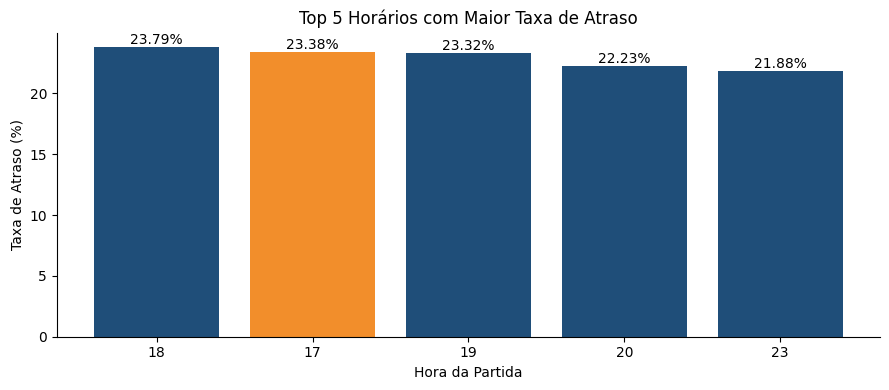

In [39]:
import matplotlib.pyplot as plt
import pandas as pd

# ===============================
# 1. Definir coluna de hora
# ===============================
df_model['hora_partida'] = df_model['hora_partida_prevista_num']

# ===============================
# 2. Calcular taxa de atraso por hora
#    (0 = pontual | 1 = atrasado)
# ===============================
atraso_por_hora = (
    df_model
    .groupby('hora_partida')['atraso_voo']
    .agg(
        total_voos='count',
        taxa_atraso='mean'
    )
    .reset_index()
)

# ===============================
# 3. Converter taxa para percentual
# ===============================
atraso_por_hora['taxa_atraso_pct'] = (
    atraso_por_hora['taxa_atraso'] * 100
).round(2)

# ===============================
# 4. Ordenar do maior para o menor
# ===============================
atraso_por_hora = atraso_por_hora.sort_values(
    by='taxa_atraso_pct',
    ascending=False
)

# ===============================
# 5. Selecionar TOP 5 horários
# ===============================
horarios_criticos = atraso_por_hora.head(5)

# ===============================
# 6. Definir cores por horário
# ===============================
def cor_por_hora(hora):
    if hora in [0, 1, 2, 3, 4, 5]:
        return '#0B1C2D'   # madrugada
    elif hora in [6, 7, 8, 9, 10, 11]:
        return '#A9A9A9'   # manhã
    elif hora in [12, 13, 14, 15, 16, 17]:
        return '#F28E2B'   # tarde
    else:
        return '#1F4E79'   # noite

cores = [
    cor_por_hora(hora)
    for hora in horarios_criticos['hora_partida']
]

# ===============================
# 7. Criar gráfico
# ===============================
plt.figure(figsize=(9, 4))
plt.bar(
    horarios_criticos['hora_partida'].astype(str),
    horarios_criticos['taxa_atraso_pct'],
    color=cores
)

# ===============================
# 8. Títulos e rótulos
# ===============================
plt.title('Top 5 Horários com Maior Taxa de Atraso')
plt.xlabel('Hora da Partida')
plt.ylabel('Taxa de Atraso (%)')

# ===============================
# 9. Remover bordas superiores
# ===============================
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# ===============================
# 10. Valores nas barras
# ===============================
for i, valor in enumerate(horarios_criticos['taxa_atraso_pct']):
    plt.text(
        i,
        valor,
        f'{valor:.2f}%',
        ha='center',
        va='bottom'
    )


# 👉 Salvar imagem
plt.savefig(
    "Taxa de atraso por horário de partida — Top 5 janelas críticas.png",
    dpi=300,
    bbox_inches="tight"
)

plt.tight_layout()
plt.show()


## 2.4. Taxa de atraso por cia aérea com limite operacional de 40%

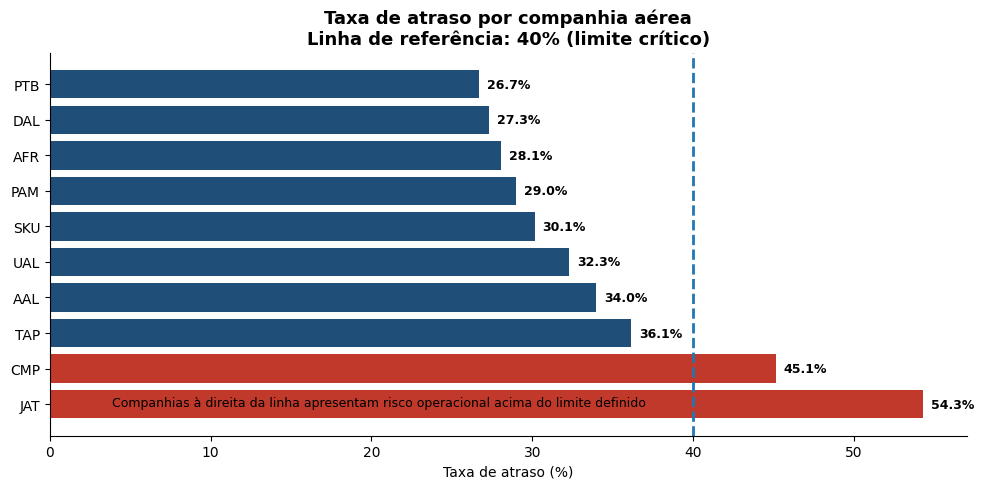

In [38]:
import matplotlib.pyplot as plt
import pandas as pd

# =========================
# Preparação dos dados
# =========================
cia_stats = (
    df_model
    .groupby('sigla_icao_empresa_aerea')
    .agg(
        total_voos=('atraso_voo', 'count'),
        taxa_atraso=('atraso_voo', 'mean')
    )
    .reset_index()
)

# Converter taxa para percentual
cia_stats['taxa_atraso_pct'] = (
    cia_stats['taxa_atraso'] * 100
).round(2)

# Filtro de volume mínimo (estabilidade estatística)
cia_stats = cia_stats[cia_stats['total_voos'] >= 1000]

# Top 10 maiores taxas de atraso
top_cias = (
    cia_stats
    .sort_values('taxa_atraso_pct', ascending=False)
    .head(10)
)

# =========================
# Parâmetros de negócio
# =========================
limite = 40  # linha de corte (40%)

# =========================
# Cores condicionais
# =========================
cores = [
    '#C0392B' if taxa >= limite else '#1F4E79'
    for taxa in top_cias['taxa_atraso_pct']
]

# =========================
# Visualização
# =========================
fig, ax = plt.subplots(figsize=(10, 5))

bars = ax.barh(
    top_cias['sigla_icao_empresa_aerea'],
    top_cias['taxa_atraso_pct'],
    color=cores
)

# 🔴 Linha horizontal de limite (40%)
ax.axvline(
    x=limite,
    linestyle='--',
    linewidth=2
)

# =========================
# Títulos e rótulos
# =========================
ax.set_title(
    'Taxa de atraso por companhia aérea\n'
    'Linha de referência: 40% (limite crítico)',
    fontsize=13,
    weight='bold'
)

ax.set_xlabel('Taxa de atraso (%)')
ax.set_ylabel('')

# =========================
# Estética limpa
# =========================
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# =========================
# Valores nas barras
# =========================
for bar in bars:
    valor = bar.get_width()
    ax.text(
        valor + 0.5,
        bar.get_y() + bar.get_height() / 2,
        f'{valor:.1f}%',
        va='center',
        fontsize=9,
        weight='bold'
    )

# =========================
# Comentário analítico
# =========================
ax.text(
    0.65, 0.07,
    'Companhias à direita da linha apresentam risco operacional acima do limite definido',
    transform=ax.transAxes,
    ha='right',
    va='bottom',
    fontsize=9,
    color='black'
)


# 👉 Salvar imagem
plt.savefig(
    "Taxa de atraso por cia aérea com limite operacional de 40%.png",
    dpi=300,
    bbox_inches="tight"
)


plt.tight_layout()
plt.show()


## 2.5. Aeroportos mais pontuais considerando volume operacional relevante

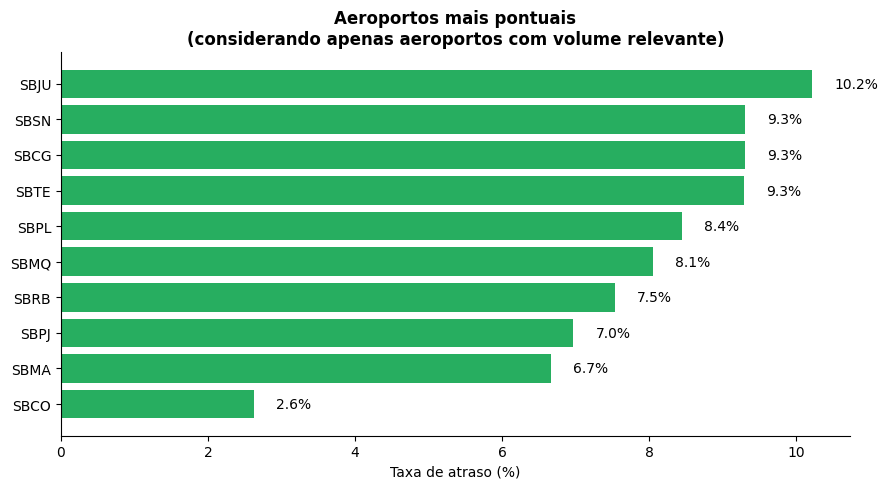

In [37]:
import matplotlib.pyplot as plt
import pandas as pd

# =========================
# Preparação dos dados
# =========================
aeroporto_stats = (
    df_model
    .groupby('sigla_icao_aeroporto_origem')
    .agg(
        total_voos=('atraso_voo', 'count'),
        taxa_atraso=('atraso_voo', 'mean')
    )
    .reset_index()
)

# Converter taxa para percentual
aeroporto_stats['taxa_atraso_pct'] = (
    aeroporto_stats['taxa_atraso'] * 100
).round(2)

# 🔒 Filtro de volume mínimo
aeroporto_stats = aeroporto_stats[
    aeroporto_stats['total_voos'] >= 500
]

# Top 10 aeroportos mais pontuais (menor taxa)
top_pontuais = (
    aeroporto_stats
    .sort_values('taxa_atraso_pct', ascending=True)
    .head(10)
)

# =========================
# Visualização
# =========================
plt.figure(figsize=(9, 5))

plt.barh(
    top_pontuais['sigla_icao_aeroporto_origem'],
    top_pontuais['taxa_atraso_pct'],
    color='#27ae60'
)

plt.title(
    'Aeroportos mais pontuais\n'
    '(considerando apenas aeroportos com volume relevante)',
    fontsize=12,
    weight='bold'
)

plt.xlabel('Taxa de atraso (%)')
plt.ylabel('')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for i, v in enumerate(top_pontuais['taxa_atraso_pct']):
    plt.text(v + 0.3, i, f'{v:.1f}%', va='center')

# 👉 Salvar imagem
plt.savefig(
    "Aeroportos mais pontuais.png",
    dpi=300,
    bbox_inches="tight"
)

plt.tight_layout()
plt.show()


## 2.6. Aeroportos com maior atraso considerando volume operacional relevante

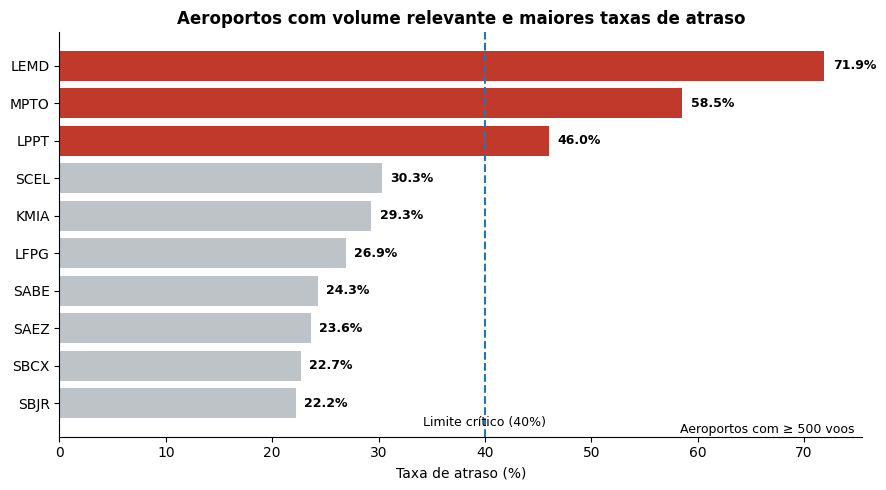

In [36]:
import matplotlib.pyplot as plt
import pandas as pd

# ===============================
# 1. Definir volume mínimo
# ===============================
VOLUME_MINIMO = 500  # ajuste conforme o dataset

# ===============================
# 2. Agregar dados por aeroporto
#    (0 = pontual | 1 = atrasado)
# ===============================
atraso_por_aeroporto = (
    df_model
    .groupby('sigla_icao_aeroporto_origem')
    .agg(
        total_voos=('atraso_voo', 'count'),
        taxa_atraso=('atraso_voo', 'mean')
    )
    .reset_index()
)

# ===============================
# 3. Filtrar aeroportos com volume relevante
# ===============================
atraso_por_aeroporto = atraso_por_aeroporto[
    atraso_por_aeroporto['total_voos'] >= VOLUME_MINIMO
]

# ===============================
# 4. Converter taxa para percentual
# ===============================
atraso_por_aeroporto['taxa_atraso_pct'] = (
    atraso_por_aeroporto['taxa_atraso'] * 100
).round(2)

# ===============================
# 5. Selecionar TOP 10 maiores atrasos
# ===============================
top_atrasos = (
    atraso_por_aeroporto
    .sort_values('taxa_atraso_pct', ascending=False)
    .head(10)
    .sort_values('taxa_atraso_pct')  # para barra horizontal
)

# ===============================
# 6. Definir cores (Top 3 em vermelho)
# ===============================
cores = [
    '#C0392B' if i >= len(top_atrasos) - 3 else '#BDC3C7'
    for i in range(len(top_atrasos))
]

# ===============================
# 7. Criar gráfico
# ===============================
fig, ax = plt.subplots(figsize=(9, 5))

bars = ax.barh(
    top_atrasos['sigla_icao_aeroporto_origem'],
    top_atrasos['taxa_atraso_pct'],
    color=cores
)

# ===============================
# 8. Título e rótulos
# ===============================
ax.set_title(
    'Aeroportos com volume relevante e maiores taxas de atraso',
    fontsize=12,
    weight='bold'
)

ax.set_xlabel('Taxa de atraso (%)')
ax.set_ylabel('')

# ===============================
# 9. Linha de referência (40%)
# ===============================
ax.axvline(
    40,
    linestyle='--',
    linewidth=1.5
)
ax.text(
    40,
    -0.6,
    'Limite crítico (40%)',
    ha='center',
    fontsize=9
)

# ===============================
# 10. Remover bordas
# ===============================
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# ===============================
# 11. Anotar valores
# ===============================
for bar in bars:
    largura = bar.get_width()
    ax.text(
        largura + 0.8,
        bar.get_y() + bar.get_height() / 2,
        f'{largura:.1f}%',
        va='center',
        fontsize=9,
        weight='bold'
    )

# ===============================
# 12. Observação metodológica
# ===============================
ax.text(
    0.99, 0.01,
    f'Aeroportos com ≥ {VOLUME_MINIMO} voos',
    transform=ax.transAxes,
    ha='right',
    fontsize=9
)

plt.tight_layout()

# 👉 Salvar imagem
plt.savefig(
    "Aeroportos menos pontuais.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


## 2.7. Risco de atraso por companhia aérea considerando volume operacional e aeroporto de origem

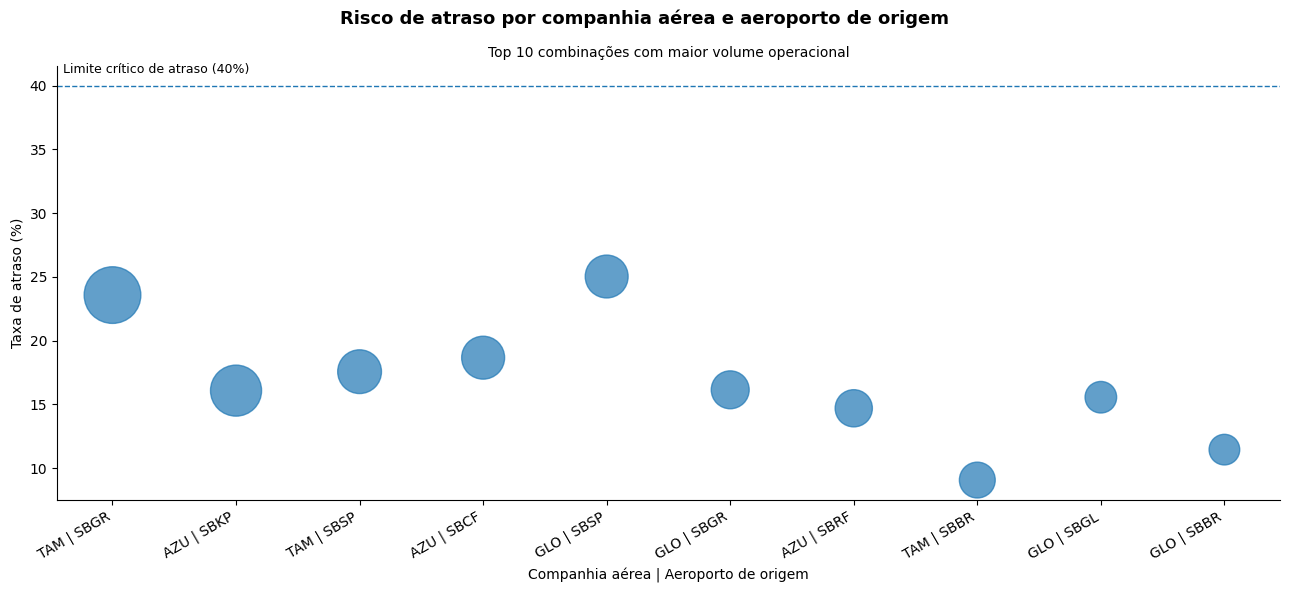

In [48]:
import matplotlib.pyplot as plt
import pandas as pd

# ===============================
# Preparação dos dados
# ===============================
bubble = (
    df_model
    .groupby(['sigla_icao_empresa_aerea', 'sigla_icao_aeroporto_origem'])
    .agg(
        taxa_atraso=('atraso_voo', 'mean'),
        total_voos=('atraso_voo', 'count')
    )
    .reset_index()
)

bubble['taxa_atraso_pct'] = bubble['taxa_atraso'] * 100

# Top 10 por volume
bubble_top10 = (
    bubble
    .sort_values('total_voos', ascending=False)
    .head(10)
)

# Criar rótulo explícito
bubble_top10['label'] = (
    bubble_top10['sigla_icao_empresa_aerea'] +
    ' | ' +
    bubble_top10['sigla_icao_aeroporto_origem']
)

bubble_top10['x'] = range(len(bubble_top10))

# ===============================
# Plot
# ===============================
plt.figure(figsize=(13, 6))

plt.scatter(
    bubble_top10['x'],
    bubble_top10['taxa_atraso_pct'],
    s=bubble_top10['total_voos'] / 15,
    alpha=0.7
)

# Linha de corte
plt.axhline(40, linestyle='--', linewidth=1)
plt.text(
    -0.4,
    41,
    'Limite crítico de atraso (40%)',
    fontsize=9
)

# ===============================
# Títulos
# ===============================
plt.suptitle(
    'Risco de atraso por companhia aérea e aeroporto de origem',
    fontsize=13,
    weight='bold'
)

plt.title(
    'Top 10 combinações com maior volume operacional',
    fontsize=10
)

# ===============================
# Eixos
# ===============================
plt.xlabel('Companhia aérea | Aeroporto de origem')
plt.ylabel('Taxa de atraso (%)')

plt.xticks(
    ticks=bubble_top10['x'],
    labels=bubble_top10['label'],
    rotation=30,
    ha='right'
)

# ===============================
# Limpeza visual
# ===============================
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


# 👉 Salvar imagem
plt.savefig(
    "Risco atraso Cia Aerea x Aeroporto.png",
    dpi=300,
    bbox_inches="tight"
)

plt.tight_layout()
plt.show()


O gráfico mostra que o risco de atraso varia conforme a combinação entre companhia aérea, aeroporto de origem e volume de voos. Companhias com grande concentração operacional em determinados aeroportos tendem a apresentar maior taxa de atraso, especialmente acima do limite crítico de 40%, indicando pontos prioritários para ações operacionais.